In [1]:
%matplotlib inline
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn.apionly as sns
mpl.style.use('seaborn-poster')
pal = sns.palettes.get_color_cycle()

import numpy as np
import pandas as pd
import bioframe
import bioframe.dask
import dask
import distributed

In [2]:
import numpy as np
import dask.array as da

def geomprog(factor, start=1):
    yield start
    while True:
        start *= factor
        yield start


def _geomrange(start, end, factor, endpoint):
    prev = np.nan
    for i in geomprog(factor, start):
        x = int(round(i))
        
        if x > end:
            break

        if x == prev:
            continue
        
        prev = x
        yield x

    if endpoint and prev != end:
        yield end


def geomrange(start, end, factor, endpoint=False):
    return np.fromiter(_geomrange(start, end, factor, endpoint), dtype=int)


def geomspace(start, end, num=50, endpoint=True):
    factor = 1 + ((np.log10(end) - np.log10(start)) / num)
    return geomrange(start, end, factor, endpoint=endpoint)


def _contact_areas(distbins, scaffold_length):
    distbins = distbins.astype(float)
    scaffold_length = float(scaffold_length)
    outer_areas = np.maximum(scaffold_length - distbins[:-1], 0) ** 2
    inner_areas = np.maximum(scaffold_length - distbins[1: ], 0) ** 2
    return 0.5 * (outer_areas - inner_areas)
    

def contact_areas(distbins, region1, region2):
    if region1 == region2:
        start, end = region1
        areas = _contact_areas(distbins, end - start)
    else:
        start1, end1 = region1
        start2, end2 = region2
        if start2 <= start1:
            start1, start2 = start2, start1
            end1, end2 = end2, end1
        areas = (
            _contact_areas(distbins, end2 - start1) -
            _contact_areas(distbins, start2 - start1) -
            _contact_areas(distbins, end2 - end1)
        )
        if end1 < start2:
            areas += _contact_areas(distbins, start2 - end1)
    
    return areas


def compute_scaling(df, region1, region2=None, 
                    dmin=int(1e1), 
                    dmax=int(1e7), 
                    n_bins=50):

    if region2 is None:
        region2 = region1
    
    distbins = geomspace(dmin, dmax, n_bins)
    areas = contact_areas(distbins, region1, region2)

    df = df[ 
        (df['pos1'] >= region1[0]) & 
        (df['pos1'] < region1[1]) & 
        (df['pos2'] >= region2[0]) & 
        (df['pos2'] < region2[1])
    ]
    dists = (df['pos2'] - df['pos1']).values

    if isinstance(dists, da.Array):
        obs, _ = da.histogram(
            dists[(dists >= dmin) & (dists < dmax)],
            bins=distbins)
    else:
        obs, _ = np.histogram(
            dists[(dists >= dmin) & (dists < dmax)],
            bins=distbins)

    return distbins, obs, areas


In [3]:
cluster = distributed.LocalCluster(n_workers=40)
client = distributed.Client(cluster)
client

<Client: scheduler='tcp://127.0.0.1:46402' processes=40 cores=40>

In [4]:
colors = {
    'U': pal[2],
    'T': pal[0],
    'N': pal[3],
}

In [5]:
chromsizes = bioframe.fetch_chromsizes('mm9')[:'chr19']
chromsizes

chr1     197195432
chr2     181748087
chr3     159599783
chr4     155630120
chr5     152537259
chr6     149517037
chr7     152524553
chr8     131738871
chr9     124076172
chr10    129993255
chr11    121843856
chr12    121257530
chr13    120284312
chr14    125194864
chr15    103494974
chr16     98319150
chr17     95272651
chr18     90772031
chr19     61342430
Name: length, dtype: int64

In [6]:
pairsU = bioframe.dask.daskify_pairix(
    'data/UNTR_R2.nodups.pairs.gz',
    chromsizes, 
    columns=['read_id', 'chrom1', 'pos1', 'chrom2', 'pos2', 'strand1', 'strand2', 'pair_type'])

pairsT = bioframe.dask.daskify_pairix(
    'data/TAM_R2.nodups.pairs.gz',
    chromsizes, 
    columns=['read_id', 'chrom1', 'pos1', 'chrom2', 'pos2', 'strand1', 'strand2', 'pair_type'])

pairsN = bioframe.dask.daskify_pairix(
    'data/NIPBL_R2.nodups.pairs.gz',
    chromsizes, 
    columns=['read_id', 'chrom1', 'pos1', 'chrom2', 'pos2', 'strand1', 'strand2', 'pair_type'])

In [7]:
dfU = pairsU['chr1', 'chr1'].compute()
dfT = pairsT['chr1', 'chr1'].compute()
dfN = pairsN['chr1', 'chr1'].compute()

In [8]:
dfU.head()

,read_id,chrom1,pos1,chrom2,pos2,strand1,strand2,pair_type
0,.,chr1,3000032,chr1,66691730,-,+,LL
1,.,chr1,3000035,chr1,4026372,-,+,LL
2,.,chr1,3000302,chr1,4430326,-,-,LL
3,.,chr1,3000356,chr1,3116276,-,-,LL
4,.,chr1,3000845,chr1,3001031,+,-,LL


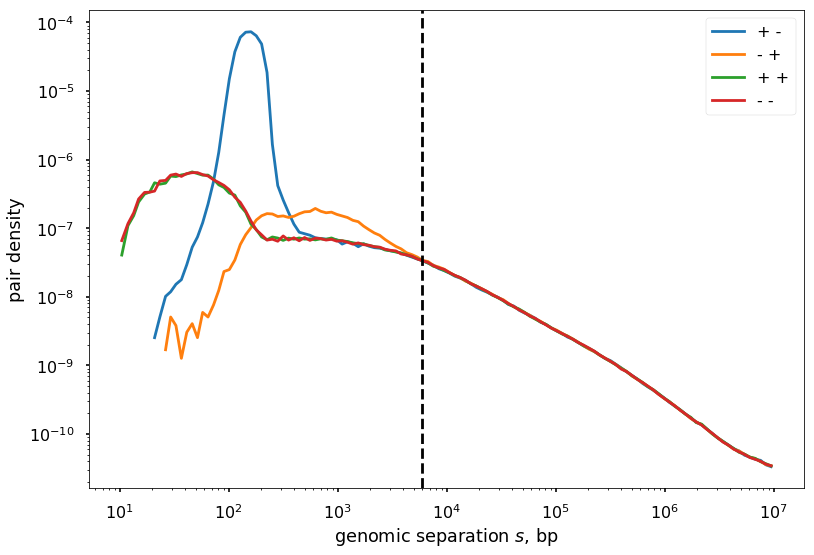

In [9]:
grouped = dfU.groupby(['strand1', 'strand2'])

orientations = [
    ('+', '-'),
    ('-', '+'),
    ('+', '+'),
    ('-', '-')
]

for s1, s2 in orientations:
    group = grouped.get_group((s1, s2))
    dbins, obs, areas = compute_scaling(
        group, 
        [0, chromsizes['chr1']], 
        [0, chromsizes['chr1']])
    dmeans = np.sqrt(dbins[:-1] * dbins[1:])
    scaling = obs / areas
    plt.loglog(dmeans, scaling, label='{} {}'.format(s1, s2))

plt.xlabel(r'genomic separation $s$, bp')
plt.ylabel('pair density')
plt.legend()
plt.axvline(6000, c='k', ls='--')

In [13]:
dbinsU, obsU, areasU = compute_scaling(dfU, [0, chromsizes['chr1']], [0, chromsizes['chr1']], dmin=1e3)
scalingU = obsU / areasU

dbinsT, obsT, areasT = compute_scaling(dfT, [0, chromsizes['chr1']], [0, chromsizes['chr1']], dmin=1e3)
scalingT = obsT / areasT

dbinsN, obsN, areasN = compute_scaling(dfN, [0, chromsizes['chr1']], [0, chromsizes['chr1']], dmin=1e3)
scalingN = obsN / areasN

ref_point = np.searchsorted(dbinsU, 6000)

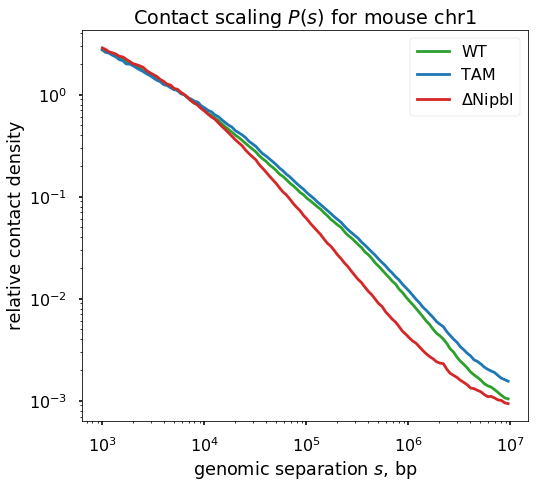

In [14]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
plt.loglog(dbinsU[:-1], scalingU / scalingU[ref_point], colors['U'], label='WT')
plt.loglog(dbinsT[:-1], scalingT / scalingT[ref_point], colors['T'], label='TAM')
plt.loglog(dbinsN[:-1], scalingN / scalingN[ref_point], colors['N'], label=r'$\Delta$Nipbl')
plt.gca().set_aspect(1)
plt.ylabel('relative contact density')
plt.xlabel(r'genomic separation $s$, bp')
plt.title(r'Contact scaling $P(s)$ for mouse chr1')
plt.legend()